In [215]:
import os
import pickle
import re
import shutil
import time
from itertools import chain
from pathlib import Path

from cytoolz import groupby, merge
from cytoolz.curried import get, get_in
from killscreen import subutils, shortcuts as ks
from killscreen.aws import ec2
import pyarrow as pa
import pyarrow.csv
from gPhoton.pretty import make_monitors
from more_itertools import distribute
from pyarrow import parquet

from s3_fuse.mount_s3 import mount_bucket
from s3_fuse.ps1_utils import prune_ps1_catalog
from s3_fuse.utilz import parse_topline, sample_table

key = "/home/ubuntu/galex_swarm.pem"
uname = "ubuntu"
DUMP_PATH = '/home/ubuntu/.slice_test/'
os.makedirs(DUMP_PATH, exist_ok=True)
S3_ROOT = "/mnt/s3"
BUCKET="nishapur"
# mount bucket to fetch metadata
mount_bucket(backend="goofys", mount_path=S3_ROOT, bucket=BUCKET)

In [2]:
# initialize a killscreen Cluster
descriptions = ec2.describe(
    tag_filters={'Name': 'fornax-slice'}, states=("running", "stopped")
)
# ...either from already-running EC2 instances...
if len(descriptions) == 0:
    cluster = ec2.Cluster.launch(
        count=4,
        template="fornax-slice", 
        key=key, 
        uname=uname, 
        use_private_ip=True
    )
# ...or from a new fleet request.
else:
    cluster = ec2.Cluster.from_descriptions(
        descriptions, key=key, uname=uname, use_private_ip=True
    )
    cluster.start()
    [instance.wait_until_running() for instance in cluster.instances]
    cluster.add_keys()
    print("\n".join([str(i) for i in cluster.instances]))

fornax-slice (i-0c27b8a6283bf253e): m6i.2xlarge in us-east-1b at 172.31.88.166
fornax-slice (i-074e19aec3492920c): m6i.2xlarge in us-east-1b at 172.31.90.67
fornax-slice (i-099889457e746957b): m6i.2xlarge in us-east-1b at 172.31.87.52
fornax-slice (i-0995d88f393c130bb): m6i.2xlarge in us-east-1b at 172.31.90.50


In [33]:
# freshen these instances
def git_update(*repo_names):
    return ks.chain(
        [f"cd {repo}; git reset --hard; git pull & cd ~" for repo in repo_names], "and"
    )
update = git_update("fornax-s3-subsets", "killscreen", "gphoton_working")
updaters = cluster.command(update, _bg=True)

In [5]:
# set up metadata objects in order to pick targets for slicing

# catalog of PS1 extragalactic extended objects, including explicit
# assignments to PS1 stack image projection / sky cells and GALEX 
# eclipse numbers (not used here)
catalog_fn = "ps1_extragalactic_skycells_eclipses.parquet"
if not Path(catalog_fn).exists():
    shutil.copy(
        Path(S3_ROOT, "ps1/metadata", catalog_fn),
        Path(catalog_fn)
    )
catalog = parquet.read_table(catalog_fn)

# for this demo, we only staged a subset of those PS1 stack images 
# (all of them at all 5 bands would be > 80 TB). this is a list of 
# the (randomly selected) projection and sky cells we staged.
test_cell_fn = "ps1_extragalactic_skycells_eclipses_1k_cell_subset.csv"
arbitrary_test_cells = (
    pa.csv.read_csv(Path(S3_ROOT, "ps1/metadata", test_cell_fn))
    .cast(pa.schema([("proj_cell", pa.uint16()), ("sky_cell", pa.uint8())]))
)
small_catalog = prune_ps1_catalog(catalog, arbitrary_test_cells)
del catalog

In [228]:
# various settings for the test

# how many objects shall we collect slices for? (785510 are available in this test set)
TARGET_COUNT = 2300
# optional parameter -- restrict the total number of PS1 source cells to test the 
# performance effects of denser sampling.
# (1000 total PS1 cells are available in this test set).
# note that the total number of images accessed is number of cells * number of bands.
MAX_CELL_COUNT = 160
if MAX_CELL_COUNT is not None:
    test_catalog = prune_ps1_catalog(
        small_catalog, sample_table(arbitrary_test_cells, k=MAX_CELL_COUNT)
    )
else:
    test_catalog = small_catalog
targets = sample_table(test_catalog, k=TARGET_COUNT).to_pylist()

# split these into chunks of work, making sure that all targets within
# a single cell / image are assigned to the same instance --
target_groups = groupby(get(['proj_cell', 'sky_cell']), targets)
# heuristic to distribute work evenly
groups = sorted(target_groups.values(), key=lambda v: 1 / len(v))
work_chunks = [
    tuple(chain.from_iterable(chunk)) 
    for chunk in distribute(len(cluster.instances), groups)
]

In [229]:
# what script / interpreter are we actually using on the remote instances
env = cluster.instances[0].conda_env("fornax-slice-testing")
python = f"{env}/bin/python"
endpoint = "/home/ubuntu/fornax-s3-subsets/s3_fuse_testing/ps1_cutout_endpoint.py"

In [230]:
# simple process join function
def wait_on(processes, polling_delay=0.1):
    while any([p.is_alive() for p in processes]):
        time.sleep(polling_delay)

# when a remote process is done, grab the files from that instance
# this could be done more concurrently, but synchronizing is a pain.
# maybe scp from remotes? ideally inside the dump loop.
getters = []
def grab_when_done(process, *_):
    print(f"{process.host.ip} done; getting files")
    getter = process.host.get(f"{DUMP_PATH}/*", DUMP_PATH, _bg=True)
    getters.append(getter)
        
# delete everything local so as to avoid confusion
subutils.run(f"rm {DUMP_PATH}/* &")

# set up some basic benchmarking...
stat, note = make_monitors(silent=True)
# ...and initiate the rmote processes
remote_processes = []
for chunk, instance in zip(work_chunks, cluster.instances):
    command = f"{python} {endpoint} '{chunk}'"
    viewer = instance.command(
        command, _bg=True, _viewer=True, _done=grab_when_done
    )
    remote_processes.append(viewer)
wait_on(remote_processes)
note(f"remote processes completed,{stat()}", True)
wait_on(getters)
note(f"cleaned up files from remotes,{stat()}", True)

retrieved_dumps = os.listdir(DUMP_PATH)

cutfiles = tuple(filter(lambda f: f.endswith("pkl"), retrieved_dumps))
note(f"got {len(targets) * 2} cuts,{stat(total=True)}", True)
log = note(None, eject=True)
rate, weight = parse_topline(log)
print(f"{rate} cutouts/s, {weight} MB / cutout (local only)")

# cleanup cached arrays on remotes
deletions = cluster.command(f"rm {DUMP_PATH}/* &", _bg=True)

172.31.87.52 done; getting files
172.31.90.67 done; getting files
172.31.88.166 done; getting files
172.31.90.50 done; getting files
remote processes completed,14.95 s,725.74 MB
cleaned up files from remotes,0.83 s,240.56 MB
got 4600 cuts,15.8 total s,966.3 total MB
291.14 cutouts/s, 0.21 MB / cutout (local only)


In [232]:
# should you like: examine logs from remotes...
import pandas as pd
logs = []
for logfile in filter(lambda f: f.endswith("csv"), retrieved_dumps):
    remote_log = pd.read_csv(Path(DUMP_PATH, logfile))
    remote_log["host"] = re.search(
        r"(?<=ip_)(\d+_){4}", logfile
    ).group(0)[:-1]
    logs.append(remote_log)
logs = pd.concat(logs)
logs.columns = ["timestamp", "event", "duration", "volume", "host"]
logs.sort_values(by=["host", "timestamp"])

,timestamp,event,duration,volume,host
0,2022-05-30T04:59:43.543233,initialized 40 images,0.69 s,15.07 MB,172_31_87_52
1,2022-05-30T04:59:48.270655,made 618 cutouts,4.73 s,1511.3 MB,172_31_87_52
2,2022-05-30T04:59:49.023962,dumped 618 cutouts to disk,0.75 s,0.0 MB,172_31_87_52
3,2022-05-30T04:59:49.610224,initialized 34 images,0.59 s,10.61 MB,172_31_87_52
4,2022-05-30T04:59:53.795919,made 510 cutouts,4.19 s,1030.47 MB,172_31_87_52
5,2022-05-30T04:59:54.403823,dumped 510 cutouts to disk,0.61 s,0.0 MB,172_31_87_52
6,2022-05-30T04:59:54.416992,made 1128 cuts from 74 images,11.57 total s,2567.45 total MB,172_31_87_52
0,2022-05-30T04:59:43.333770,initialized 40 images,0.59 s,12.97 MB,172_31_88_166
1,2022-05-30T04:59:47.655675,made 596 cutouts,4.32 s,1035.71 MB,172_31_88_166
2,2022-05-30T04:59:48.370795,dumped 596 cutouts to disk,0.72 s,0.0 MB,172_31_88_166


In [233]:
# ...or your winnings
cuts = []
for file in cutfiles:
    with open(Path(DUMP_PATH, file), "rb") as stream:
        cuts.append(pickle.load(stream))
cuts = merge(cuts)
arrays = tuple(map(get_in(['arrays', 0]), cuts.values()))

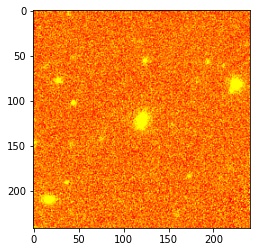

In [260]:
from random import choice
import matplotlib.pyplot as plt
import numpy as np
array = arrays[choice(range(len(arrays)))]
clipped = np.clip(array, *np.percentile(array, (1, 99)))
plt.imshow(clipped, cmap='autumn')

In [261]:
# destroy the cluster if you are done with it
cluster.terminate()